# Proyecto: Recuperación de Oro Sección 

## 1. Preparación de Datos

**Rutas de archivos**  
- `/datasets/gold_recovery_train.csv`  
- `/datasets/gold_recovery_test.csv`  
- `/datasets/gold_recovery_full.csv`  

Este notebook cubre las secciones **1.1 a 1.4**:
    
1.1 Abrir y examinar los datos  
    1.2 Verificar el cálculo de `rougher.output.recovery` (EAM/MAE)  
    1.3 Analizar las características no disponibles en el conjunto de prueba  
    1.4 Preprocesamiento de datos


In [5]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import matplotlib.pyplot as plt

# Reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


train_path = Path('/datasets/gold_recovery_train.csv')
test_path  = Path('/datasets/gold_recovery_test.csv')
full_path  = Path('/datasets/gold_recovery_full.csv')


## 1.1 Abrir y examinar los datos

In [6]:
# Carga de datos

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)
df_full  = pd.read_csv(full_path)


print('Dimensiones:')
print("="*60)
print(f'- train: {df_train.shape}')
print(f'- test : {df_test.shape}')
print(f'- full : {df_full.shape}\n')

print('Primeras filas (train):')
print("="*60)
display(df_train.head())

print('\nTipos de datos (train):')
print("="*60)
display(df_train.dtypes.sort_index())

print('\nResumen de valores faltantes en train (top 20 por NaN):')
print("="*60)
na_train = df_train.isna().sum().sort_values(ascending=False)
display(na_train[na_train>0].head(20))

print('\nResumen de valores faltantes en test (top 20 por NaN):')
print("="*60)
na_test = df_test.isna().sum().sort_values(ascending=False)
display(na_test[na_test>0].head(20))


Dimensiones:
- train: (16860, 87)
- test : (5856, 53)
- full : (22716, 87)

Primeras filas (train):


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691



Tipos de datos (train):


date                                           object
final.output.concentrate_ag                   float64
final.output.concentrate_au                   float64
final.output.concentrate_pb                   float64
final.output.concentrate_sol                  float64
                                               ...   
secondary_cleaner.state.floatbank5_a_level    float64
secondary_cleaner.state.floatbank5_b_air      float64
secondary_cleaner.state.floatbank5_b_level    float64
secondary_cleaner.state.floatbank6_a_air      float64
secondary_cleaner.state.floatbank6_a_level    float64
Length: 87, dtype: object


Resumen de valores faltantes en train (top 20 por NaN):


rougher.output.recovery                     2573
rougher.output.tail_ag                      2250
rougher.output.tail_sol                     2249
rougher.output.tail_au                      2249
secondary_cleaner.output.tail_sol           1986
rougher.input.floatbank11_xanthate          1904
final.output.recovery                       1521
primary_cleaner.input.sulfate               1307
primary_cleaner.input.depressant            1262
rougher.calculation.au_pb_ratio             1242
rougher.input.floatbank10_sulfate           1044
primary_cleaner.input.xanthate               985
primary_cleaner.output.concentrate_sol       636
rougher.input.floatbank11_sulfate            623
rougher.state.floatbank10_e_air              603
rougher.input.feed_rate                      513
rougher.input.feed_size                      417
final.output.concentrate_sol                 370
secondary_cleaner.state.floatbank2_a_air     363
primary_cleaner.output.concentrate_pb        358
dtype: int64


Resumen de valores faltantes en test (top 20 por NaN):


rougher.input.floatbank11_xanthate            353
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
rougher.input.floatbank10_sulfate             257
primary_cleaner.input.xanthate                166
rougher.input.floatbank10_xanthate            123
rougher.input.feed_sol                         67
rougher.input.floatbank11_sulfate              55
rougher.input.feed_rate                        40
secondary_cleaner.state.floatbank3_a_air       34
secondary_cleaner.state.floatbank2_b_air       23
rougher.input.feed_size                        22
secondary_cleaner.state.floatbank2_a_air       20
rougher.state.floatbank10_a_air                17
rougher.state.floatbank10_c_air                17
rougher.state.floatbank10_d_air                17
rougher.state.floatbank10_e_air                17
rougher.state.floatbank10_b_air                17
rougher.state.floatbank10_f_air                17
secondary_cleaner.state.floatbank3_a_level     16


Los números obtenidos muestran cuántas observaciones faltan para cada variable. Por ejemplo:
- rougher.input.floatbank11_xanthate: 353 = faltan 353 mediciones de este químico

Patrones importantes que observo:
 1. Químicos con más faltantes
- floatbank11_xanthate (353 faltantes)
- primary_cleaner.input.sulfate (302 faltantes)
- primary_cleaner.input.depressant (284 faltantes)

¿Por qué? Estos químicos se agregan condicionalmente, solo cuando es necesario ajustar el proceso.

 2. Variables de estado del aire
- floatbank2_a_air, floatbank3_a_air con muchos faltantes
- Las celdas de flotación pueden estar inactivas en ciertos momentos

 3. Diferencia entre train y test
- Train: final.output.concentrate_sol (370 faltantes)
- Test: rougher.input.floatbank11_xanthate (353 faltantes)

## 1.2 Verificar cálculo de `rougher.output.recovery` (EAM/MAE)



In [7]:

from sklearn.metrics import mean_absolute_error

# Fórmula de recuperación:
def compute_recovery(C, F, T):
    num = C * (F - T)
    den = F * (C - T)
    return (num / den) * 100

# Columnas esperadas para rougher
col_F = 'rougher.input.feed_au'
col_C = 'rougher.output.concentrate_au'
col_T = 'rougher.output.tail_au'
col_rec = 'rougher.output.recovery'

missing_cols = [c for c in [col_F, col_C, col_T, col_rec] if c not in df_train.columns]
if missing_cols:
    raise ValueError(f'Faltan columnas esperadas en train para la verificación: {missing_cols}')

# Cálculo y comparación (dropna coordinado)
tmp = df_train[[col_F, col_C, col_T, col_rec]].dropna()
recovery_calc = compute_recovery(tmp[col_C], tmp[col_F], tmp[col_T])
recovery_true = tmp[col_rec]

mae = mean_absolute_error(recovery_true, recovery_calc)
print(f'EAM/MAE entre recovery calculado y columna original: {mae:.6f}')

# Distribución de diferencias para inspección rápida
diff = (recovery_true - recovery_calc).abs()
print('\nResumen de |true - calc|:')
display(diff.describe())


EAM/MAE entre recovery calculado y columna original: 0.000000

Resumen de |true - calc|:


count    1.428700e+04
mean     9.303416e-15
std      1.051342e-14
min      0.000000e+00
25%      0.000000e+00
50%      1.421085e-14
75%      1.421085e-14
max      7.105427e-14
dtype: float64

¿Qué significa MAE = 0.000000?
El MAE de 0.000000 indica que la fórmula de cálculo de recovery está perfectamente correcta. Esto significa que:

1. Los valores calculados con la fórmula coinciden exactamente con los valores originales de la columna
2. No hay diferencia práctica entre lo que se calcula y lo que debería ser
   
¿Por qué aparecen números tan pequeños en el resumen?
Los números (como 9.303416e-15) son errores de precisión numérica de la computadora. Estos números son prácticamente cero para efectos prácticos

## 1.3 Analizar características no disponibles en el conjunto de prueba

In [8]:
import pandas as pd

# Columnas presentes solo en train
cols_only_train = sorted(set(df_train.columns) - set(df_test.columns))
print("="*60)
print(f"Número de columnas presentes solo en train: {len(cols_only_train)}")
print("="*60)
print("")
print("\nLista de columnas exclusivas en train (primeras 20):")
print("-"*60)
for col in cols_only_train[:20]:
    print(f"• {col}")
if len(cols_only_train) > 20:
    print(f"... y {len(cols_only_train) - 20} más")

# Clasificación por tipo de parámetro
def parse_param_type(colname: str) -> str:
    parts = colname.split('.')
    return parts[1] if len(parts) >= 3 else 'unknown'

df_missing = pd.DataFrame({
    'column': cols_only_train,
    'parameter_type': [parse_param_type(c) for c in cols_only_train]
})

# Conteo por tipo
print("")
print("\nConteo por tipo de parámetro:")
print("-"*60)
type_counts = df_missing['parameter_type'].value_counts()
for param_type, count in type_counts.items():
    print(f"{param_type:<12}: {count} columnas")

# Ejemplos por tipo
print("")
print("\n Ejemplos de columnas ausentes por tipo (máximo 10 por tipo):")
print("-"*60)
for param_type in ['input', 'state', 'calculation', 'output', 'unknown']:
    subset = df_missing[df_missing['parameter_type'] == param_type]['column'].head(10)
    if not subset.empty:
        print(f"\nTIPO DE COLUMNA: {param_type} ({len(subset)} ejemplos)")
        for col in subset:
            print(f"   • {col}")


Número de columnas presentes solo en train: 34


Lista de columnas exclusivas en train (primeras 20):
------------------------------------------------------------
• final.output.concentrate_ag
• final.output.concentrate_au
• final.output.concentrate_pb
• final.output.concentrate_sol
• final.output.recovery
• final.output.tail_ag
• final.output.tail_au
• final.output.tail_pb
• final.output.tail_sol
• primary_cleaner.output.concentrate_ag
• primary_cleaner.output.concentrate_au
• primary_cleaner.output.concentrate_pb
• primary_cleaner.output.concentrate_sol
• primary_cleaner.output.tail_ag
• primary_cleaner.output.tail_au
• primary_cleaner.output.tail_pb
• primary_cleaner.output.tail_sol
• rougher.calculation.au_pb_ratio
• rougher.calculation.floatbank10_sulfate_to_au_feed
• rougher.calculation.floatbank11_sulfate_to_au_feed
... y 14 más


Conteo por tipo de parámetro:
------------------------------------------------------------
output      : 30 columnas
calculation : 4 columnas


 Ejemp

1. ¿Por qué faltan estas columnas en test?
Es completamente normal y esperado porque:
- Variables objetivo (target): 
final.output.recovery = lo que quieres predecir
final.output.concentrate_* = resultados finales
- Variables de salida (output):
Son consecuencias del proceso, no causas
En producción real, no las conoces de antemano
- Variables calculadas (calculation):
Se derivan de las variables de salida
Como au_pb_ratio = proporción oro/plomo en el producto final

2. ¿Qué significa para el modelo?
Solo se pueden usar como features:
- Variables de input (materia prima, químicos)
- Variables de state (estado de las máquinas)
- NO las variables de output o calculation

3. ¿Por qué el dataset de test no tiene final.output.recovery?
En producción: Cuando el modelo esté funcionando en la planta, no se tiene el resultado de recuperación final antes de hacer la predicción.
Propósito del modelo: ¿Para qué sirve predecir algo que ya conoces?
El dataset de test simula exactamente esta situación real. Si se tuvieran las variables objetivo (final.output.recovery y rougher.output.recovery) en el test, ¡no sería necesario un modelo predictivo!

4. Sobre la importancia de las variables
- Concentraciones de entrada (rougher.input.feed_*)
    - Son la "materia prima" del proceso
    - Determinan qué tienes para trabajar desde el inicio
    - Si entra poco oro (feed_au), ¿puedes recuperar mucho oro?
    - Principio fundamental: No puedes sacar más de lo que entra

- Estados de las máquinas (*.state.*)
    - Son condiciones operativas (aire, niveles)
    - Afectan la eficiencia del proceso
    - Pero si no hay oro en la materia prima, ¡no importa qué tan bien funcionen las máquinas!


## 1.4 Preprocesamiento de datos

**Objetivos del preprocesamiento**  
- Evitar *data leakage*: no usar columnas `*.output.*` como *features*.  
- Alinear columnas entre train y test (usar solo features comunes).  
- Separar objetivos (targets):  
  - `rougher.output.recovery`  
  - `final.output.recovery`  
- Imputar valores faltantes en *features* con la mediana (calculada en train) y aplicar a test.  
- Estandarización/escala se hará en el pipeline del modelado.


In [9]:

# ==============================
# Cambiar tipo de dato a datetime
# ==============================
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S')
df_test['date']  = pd.to_datetime(df_test['date'],  format='%Y-%m-%d %H:%M:%S')

In [10]:
def impute_dataset(df, medians, modes):
    """Imputa NaN en un dataset dado, usando mediana y moda precalculada."""
    df = df.copy()
    
    # Solo imputar columnas que existen en el dataset actual
    for col in medians.index:
        if col in df.columns:  # ← Esta es la corrección clave
            df[col] = df[col].fillna(medians[col])
    
    for col in modes.index:
        if col in df.columns:  # ← Esta es la corrección clave
            df[col] = df[col].fillna(modes[col])
    
    return df

# Calcular estadísticas en train
num_cols = df_train.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df_train.select_dtypes(include=['object']).columns

medians = df_train[num_cols].median()
modes = df_train[cat_cols].mode().iloc[0] if len(cat_cols) > 0 else pd.Series(dtype=object)

# Imputar en cada dataset
df_train = impute_dataset(df_train, medians, modes)
df_test = impute_dataset(df_test, medians, modes)
df_full = impute_dataset(df_full, medians, modes)

def missing_percentage(df, name="dataset"):
    total = df.size
    missing = df.isna().sum().sum()
    perc = (missing / total) * 100
    print(f"Porcentaje de valores ausentes en {name}: {perc:.2f}%")
    return perc


missing_percentage(df_train, "train")
missing_percentage(df_test, "test")
missing_percentage(df_full, "full")


Porcentaje de valores ausentes en train: 0.00%
Porcentaje de valores ausentes en test: 0.00%
Porcentaje de valores ausentes en full: 0.00%


0.0

In [11]:


# Definir targets
TARGET_ROUGHER = 'rougher.output.recovery'
TARGET_FINAL   = 'final.output.recovery'

targets = [c for c in [TARGET_ROUGHER, TARGET_FINAL] if c in df_train.columns]
if len(targets) < 2:
    print('Advertencia: no se encontraron ambos targets en train. Targets detectados:', targets)

# Selección de features seguros (sin *.output.*)
def is_safe_feature(col: str):
    if col in targets:
        return False
    parts = col.split('.')
    if len(parts) >= 2 and parts[1] == 'output':
        return False
    return True

# Features candidatos en train y test
feat_train_all = [c for c in df_train.columns if is_safe_feature(c)]
feat_test_all  = [c for c in df_test.columns if is_safe_feature(c)]

# Alinear por intersección (comunes)
feat_common = sorted(list(set(feat_train_all).intersection(set(feat_test_all))))

print(f'Features candidatos en train (sin output): {len(feat_train_all)}')
print(f'Features candidatos en test  (sin output): {len(feat_test_all)}')

# Construir X, y
X_train = df_train[feat_common].copy()
y_train = df_train[targets].copy() if all(t in df_train.columns for t in targets) else None
X_test  = df_test[feat_common].copy()

# Features que están en train pero no en test
diff_train_only = sorted(list(set(feat_train_all) - set(feat_test_all)))

# Features que están en test pero no en train (por completitud)
diff_test_only = sorted(list(set(feat_test_all) - set(feat_train_all)))

print("Features SOLO en train:", diff_train_only)
print("Features SOLO en test :", diff_test_only)

print(f'Features comunes (train ∩ test): {len(feat_common)}')


Features candidatos en train (sin output): 57
Features candidatos en test  (sin output): 53
Features SOLO en train: ['rougher.calculation.au_pb_ratio', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.sulfate_to_au_concentrate']
Features SOLO en test : []
Features comunes (train ∩ test): 53


En mi df_train y df_test había muchas columnas, pero quité todas las que son targets (rougher.output.recovery y final.output.recovery) y todas las que contienen .output. porque esas son resultados del proceso, no deben usarse como predictores.

Para poder entrenar y evaluar un modelo, se necesita que X_train y X_test tengan exactamente las mismas columnas.

Por eso, se debe de tomar la intersección de ambas listas (feat_train_all ∩ feat_test_all), que resultan 53 columnas comunes.

Esto quiere decir que: 4 columnas están en train pero no en test.

# 02. Análisis exploratorio de datos (EDA)
## 2.1 Comparación de train y test

Shape train: (16860, 53)
Shape test: (5856, 53)


,count,mean,std,min,25%,50%,75%,max
primary_cleaner.input.depressant,16860.0,8.579474,3.561110,0.000000,6.028747,8.016531,11.004224,40.000000
primary_cleaner.input.feed_size,16860.0,7.297285,0.619166,1.080000,6.940000,7.285000,7.700000,10.470000
primary_cleaner.input.sulfate,16860.0,129.658344,43.596476,0.000003,105.698879,131.783108,156.728392,251.999948
primary_cleaner.input.xanthate,16860.0,0.843839,0.406671,0.000005,0.592487,0.844271,1.089204,6.027907
primary_cleaner.state.floatbank8_a_air,16860.0,1521.481128,379.633188,0.000000,1504.162089,1601.139322,1699.296724,2079.531340
primary_cleaner.state.floatbank8_a_level,16860.0,-505.799634,77.564693,-800.037388,-500.413514,-499.951772,-499.413600,-330.134203
primary_cleaner.state.floatbank8_b_air,16860.0,1524.063279,380.811325,0.000000,1503.035817,1601.125754,1699.982559,2361.414084
primary_cleaner.state.floatbank8_b_level,16860.0,-507.334318,79.767331,-800.409770,-500.490252,-499.985447,-499.438839,-336.237097
primary_cleaner.state.floatbank8_c_air,16860.0,1514.546219,396.067280,0.000000,1500.721701,1600.908740,1700.213827,2042.072583
primary_cleaner.state.floatbank8_c_level,16860.0,-507.082933,78.760532,-800.362914,-500.858202,-499.950634,-498.905249,-221.857683


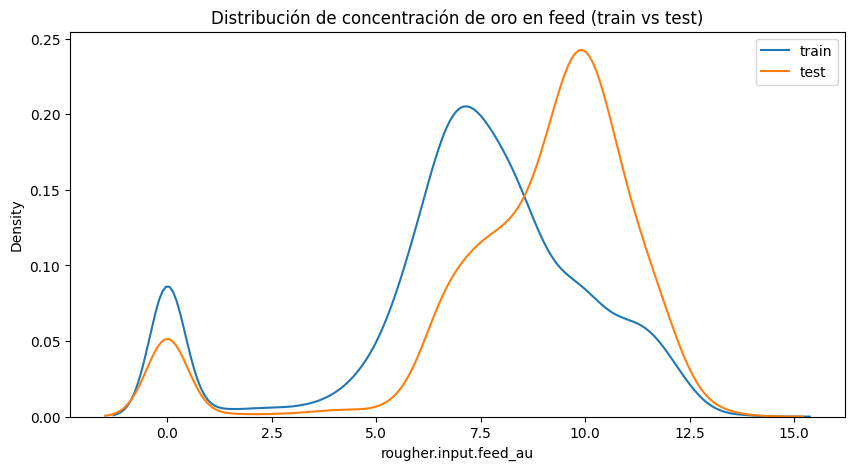

In [12]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

print("Shape train:", X_train.shape)
print("Shape test:", X_test.shape)

# Estadísticos descriptivos
display(X_train.describe().T.head(10))

# Comparación de distribuciones (ejemplo: rougher.input.feed_au)
plt.figure(figsize=(10,5))
sns.kdeplot(X_train['rougher.input.feed_au'], label="train")
sns.kdeplot(X_test['rougher.input.feed_au'], label="test")
plt.legend()
plt.title("Distribución de concentración de oro en feed (train vs test)")
plt.show()


## 2.2 Distribución de concentraciones de metales

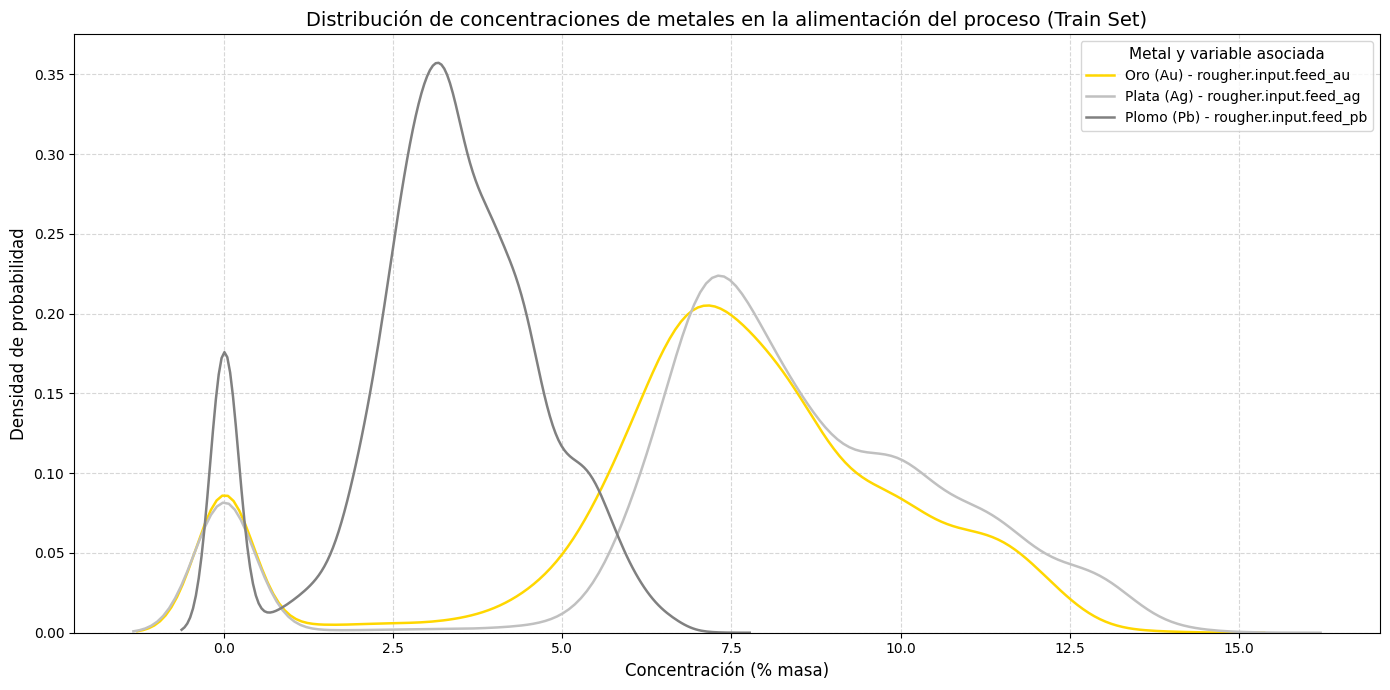

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de metales relevantes en el proceso de extracción
metales = ['au', 'ag', 'pb']
nombres_quimicos = {'au': 'Oro (Au)', 'ag': 'Plata (Ag)', 'pb': 'Plomo (Pb)'}
colores = {'au': 'gold', 'ag': 'silver', 'pb': 'gray'}

plt.figure(figsize=(14, 7))

for metal in metales:
    cols = [c for c in X_train.columns if c.endswith(metal)]
    if not cols:
        continue

    for col in cols[:5]:  # máximo 5 columnas por metal
        sns.kdeplot(
            X_train[col],
            label=f"{nombres_quimicos[metal]} - {col}",
            linewidth=1.8,
            color=colores[metal]
        )

# Título más descriptivo para el contexto químico
plt.title("Distribución de concentraciones de metales en la alimentación del proceso (Train Set)", fontsize=14)

# Etiquetas de ejes más técnicas
plt.xlabel("Concentración (% masa)", fontsize=12)
plt.ylabel("Densidad de probabilidad", fontsize=12)

# Leyenda explicativa
plt.legend(title="Metal y variable asociada", fontsize=10, title_fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 2.3 Balance de metales

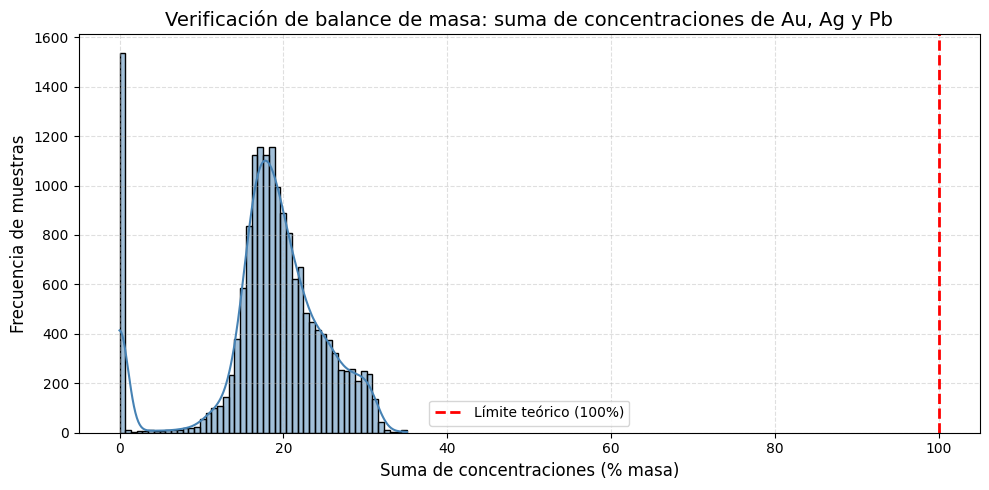

Muestras con suma de metales > 100%: 0


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selección de columnas que contienen concentraciones de metales relevantes
concentraciones = [c for c in X_train.columns if any(m in c for m in ['au', 'ag', 'pb'])]

# Cálculo de la suma total de concentraciones por muestra
X_train['suma_metales'] = X_train[concentraciones].sum(axis=1)

plt.figure(figsize=(10, 5))
sns.histplot(X_train['suma_metales'], bins=50, kde=True, color='steelblue')

# Línea de referencia en 100% de concentración total
plt.axvline(100, color="red", linestyle="--", linewidth=2, label="Límite teórico (100%)")

# Título más técnico y explicativo
plt.title("Verificación de balance de masa: suma de concentraciones de Au, Ag y Pb", fontsize=14)

# Etiquetas de ejes más precisas
plt.xlabel("Suma de concentraciones (% masa)", fontsize=12)
plt.ylabel("Frecuencia de muestras", fontsize=12)

# Leyenda para destacar el umbral crítico
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Reporte de muestras con inconsistencias
exceso = (X_train['suma_metales'] > 100).sum()
print(f"Muestras con suma de metales > 100%: {exceso}")


## 2.4 Correlaciones

In [15]:
# Filtrar solo columnas numéricas
numeric_cols = df_full.select_dtypes(include='number')

# Calculamos la correlación
corr = numeric_cols.corr()

# Verifica qué columnas tienes disponibles
print("Columnas disponibles en corr:")
print(corr.columns.tolist())

# Verifica las dimensiones
print(f"\nDimensiones de corr: {corr.shape}")

Columnas disponibles en corr:
['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.state.floatbank8_a_level', 'primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_b_level', 'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_c_level', 'primary_cleaner.state.f

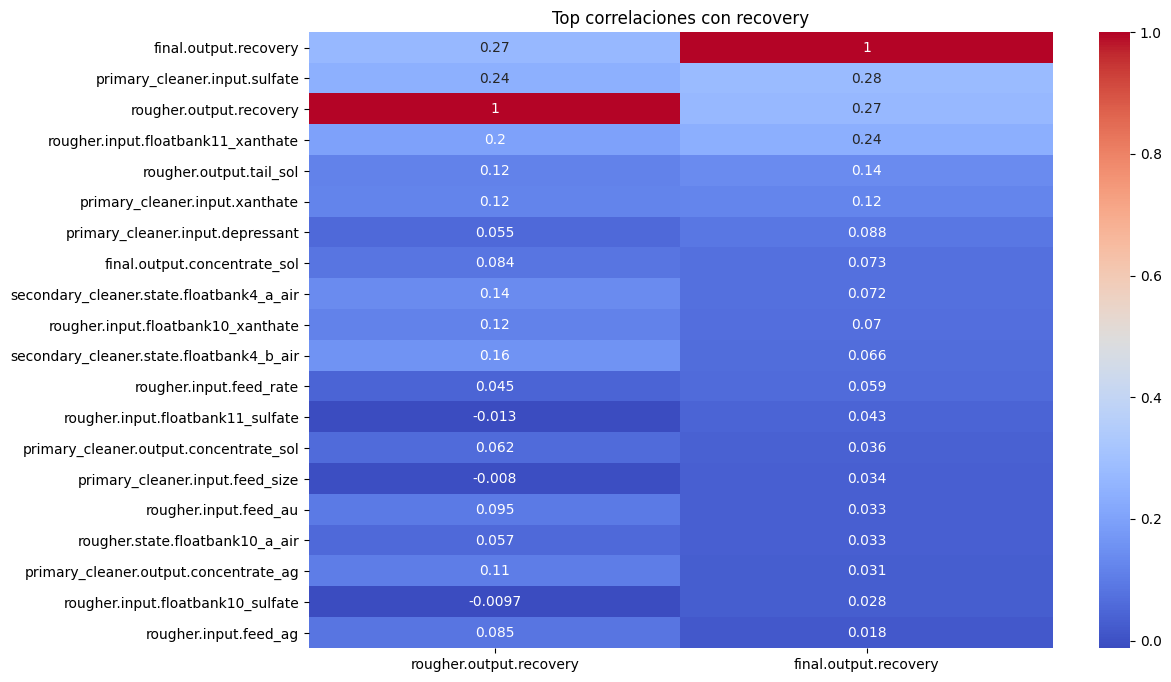

In [16]:
# Si existen las columnas de recuperación
targets = ['rougher.output.recovery','final.output.recovery']
targets = [t for t in targets if t in corr.columns]

plt.figure(figsize=(12,8))
sns.heatmap(corr[targets].sort_values(by=targets[-1], ascending=False).head(20),annot=True, cmap="coolwarm")
plt.title("Top correlaciones con recovery")
plt.show()

# 3. Entrenamiento de Modelos y Validación Cruzada

Se comienza con la definición de las funciones para el cálculo de sMAPE. El Error Porcentual Absoluto Medio Simétrico (SMAPE) es una métrica esencial para evaluar la fiabilidad de un modelo de Machine Learning, especialmente en tareas de pronóstico de series temporales, por su enfoque simétrico y su capacidad para manejar diferentes escalas de datos. 

Mide la diferencia porcentual entre los valores reales y los pronosticados. A diferencia del MAPE, el SMAPE es "simétrico" porque considera el promedio de los valores reales y pronosticados en su denominador, lo que lo hace más equilibrado al penalizar por igual los errores de sobreestimación y subestimación. Su valor ideal es 0, lo que indica una predicción perfecta, y el objetivo es minimizar esta puntuación

In [21]:
import numpy as np
import pandas as pd

from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    return (1 / len(y_true)) * np.sum(
        np.where(mask, np.abs(y_pred - y_true) / denominator, 0)
    ) * 100

def smape_final(y_true, y_pred):
    s1 = smape(y_true[:, 0], y_pred[:, 0])  # rougher
    s2 = smape(y_true[:, 1], y_pred[:, 1])  # final
    return 0.25 * s1 + 0.75 * s2

smape_scorer = make_scorer(smape_final, greater_is_better=False)

## 3.1 Preparación de datos para modelado
En esta sección se separan las variables predictoras (*features*) y las variables objetivo (*targets*), además de aplicar estandarización para mejorar el desempeño de algunos algoritmos.

In [22]:
#datetime_cols = X_train.select_dtypes(include=['datetime64']).columns
#X_train = X_train.drop(columns=datetime_cols)
#X_test = X_test.drop(columns=datetime_cols)

TARGET_ROUGHER = "rougher.output.recovery"
TARGET_FINAL = "final.output.recovery"

# Eliminar columnas no numéricas
non_numeric_cols = X_train.select_dtypes(exclude=[np.number]).columns
X_train = X_train.drop(columns=non_numeric_cols)
X_test = X_test.drop(columns=non_numeric_cols)
print("Columnas eliminadas por no ser numéricas:", non_numeric_cols.tolist())

# Variables objetivo
y = df_train[[TARGET_ROUGHER, TARGET_FINAL]].values

Columnas eliminadas por no ser numéricas: []


 
## 3.2 Entrenamiento de modelos con validación cruzada

1. Definición de modelos


##### a) LinearRegression

- Es el modelo más básico.

- Encuentra una línea recta (o un plano, o un hiperplano si tienes más variables) que mejor se ajuste a los datos.

- Ejemplo simple: predecir la altura de una persona a partir de su edad.

##### b) Ridge Regression

- Es como la LinearRegression, pero con una regla extra: penaliza los coeficientes muy grandes para evitar que el modelo “se emocione demasiado” y se adapte demasiado a los datos (lo que se llama overfitting).

- alpha=1.0 controla qué tan fuerte es esa penalización.

##### c) Lasso Regression

- También es una regresión lineal con penalización, pero diferente a Ridge.

- Lasso tiene la particularidad de que puede “apagar” variables poco importantes y dejar sus coeficientes en cero.

- Sirve como técnica de selección de variables: automáticamente descarta lo que no aporta.

- max_iter=5000 significa que puede iterar hasta 5000 veces para encontrar la mejor solución.

##### d) Random Forest Regressor

- Es un conjunto de árboles de decisión (como un bosque de decisiones).

- Cada árbol hace predicciones, y luego se toma un promedio de todos.

- Ventaja: muy bueno para capturar relaciones complejas sin necesidad de que el humano le diga “cómo debería ser la forma de la curva”.

- n_estimators=100 → se usan 100 árboles.

##### e) Gradient Boosting Regressor

- También usa árboles de decisión, pero en lugar de entrenarlos todos al mismo tiempo como Random Forest, los entrena uno tras otro, corrigiendo los errores del anterior.

- Es más lento, pero muchas veces más preciso.

- n_estimators=200 → se van a entrenar 200 árboles en secuencia.


In [24]:

cv = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.001, random_state=42, max_iter=5000),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
}

results = {}


2. Validación cruzada K-Fold

La validación cruzada K-Fold es una técnica robusta que se utiliza para evaluar el rendimiento de los modelos de aprendizaje automático.

KFold dividirá el conjunto de datos en un número predefinido de pliegues, y cada muestra debe estar en un solo pliegue. Un pliegue es un subconjunto del conjunto de datos. 

Imagina que tienes un cuaderno con 100 hojas (tus datos). Si entrenas un modelo usando siempre las mismas 80 hojas y pruebas con las mismas 20, corres el riesgo de que el modelo “aprenda de memoria” cosas específicas y no sea bueno con datos nuevos.

KFold evita eso dividiendo el cuaderno en varias partes (llamadas folds).

n_splits=5 → divide tus datos en 5 partes.

shuffle=True → mezcla los datos antes de dividir (para que no queden sesgados si estaban en orden).

random_state=42 → es como fijar una "semilla" en la lotería, garantiza que siempre se mezcle de la misma manera y obtengas resultados reproducibles.

RESULTADO: el modelo se entrena y evalúa varias veces en diferentes trozos de datos, y se promedian los resultados.

In [ ]:
for name, model in models.items():
    pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("regressor", MultiOutputRegressor(model))
    ])
    scores = cross_val_score(pipeline, X_train, y, cv=cv, scoring=smape_scorer)
    results[name] = scores.mean()
    print(f"{name} -> sMAPE promedio CV: {scores.mean():.4f}")

LinearRegression -> sMAPE promedio CV: -10.2437
Ridge -> sMAPE promedio CV: -10.1924
Lasso -> sMAPE promedio CV: -10.1910
RandomForest -> sMAPE promedio CV: -7.1597


In [ ]:
best_model_name = min(results, key=results.get)
print(f"\nMejor modelo según CV: {best_model_name}")

3. Entrenar modelo final

In [ ]:
best_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("regressor", MultiOutputRegressor(models[best_model_name]))
])

best_model.fit(X_train, y)


## 3.3 Métricas de desempeño
Se evalúa el desempeño de los modelos con las métricas RMSE (Error Cuadrático Medio) y MAE (Error Absoluto Medio).  
Se comparan los resultados para seleccionar el mejor modelo.


In [ ]:

# Comparar nombres de columnas
train_cols = set(X_train.columns)
test_cols = set(X_test.columns)

#print("Columnas en train pero NO en test:")
#print(train_cols - test_cols)

#print("\nColumnas en test pero NO en train:")
#print(test_cols - train_cols)

X_test['suma_metales'] = (
    X_test['rougher.input.feed_au'] + 
    X_test['rougher.input.feed_ag'] + 
    X_test['rougher.input.feed_pb']
)

print("Columnas en train agregada a test:")
print(train_cols - test_cols)

X_test viene de df_test, que es un archivo separado (test_path) y no contiene las columnas objetivo (rougher.output.recovery y final.output.recovery). Por ello, no se puede generar y_test real para ese conjunto, porque esos valores no están en el archivo.

Esto es típico en competiciones tipo Kaggle: el set de test solo sirve para enviar predicciones y que la plataforma calcule la métrica.

Para ver sMAPE, MAE y RMSE con datos reales, esto se hará:

1. Simular un test local Dividir df_train en X_train, y_train y X_val, y_val usando train_test_split o KFold. Así tendrás y_val para calcular métricas.

2. Mantener el flujo actual Usar validación cruzada con tus métricas personalizadas para estimar el rendimiento antes de predecir sobre df_test.

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir train en entrenamiento y validación
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Entrenar con el mejor modelo encontrado
best_model.fit(X_tr, y_tr)

# Predecir sobre validación
y_val_pred = best_model.predict(X_val)

# Calcular métricas
smape_val = smape_final(y_val.values, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)

print(f"sMAPE: {smape_val:.4f}")
print(f"MAE:   {mae_val:.4f}")
print(f"RMSE:  {rmse_val:.4f}")